<a href="https://colab.research.google.com/github/Srihari293/AI_ML/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distaster Prediction from Tweets using NLP

## Dependencies

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-916c7f7c-a0a4-ce64-8be5-2428c4967bc3)


In [2]:
# Importing helper functions
!wget https://raw.githubusercontent.com/Srihari293/AI_ML/main/Courses/NLP/helper_functions.py

--2023-02-02 06:29:19--  https://raw.githubusercontent.com/Srihari293/AI_ML/main/Courses/NLP/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10115 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.88K  --.-KB/s    in 0s      

2023-02-02 06:29:19 (106 MB/s) - ‘helper_functions.py’ saved [10115/10115]



In [3]:
# Import essential functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
# Get dataset from Kaggle
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-02-02 06:29:22--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-02-02 06:29:22 (106 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Understanding the data

In [5]:
# Data visualization
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=67) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
3299,4729,evacuate,NaN,Pls can alllll the nittys evacuate stockwell,0
4190,5953,hazard,NaN,Davis's Drug Guide for Nurses by Judith Hopfer...,0
2914,4183,drown,NaN,This weekend is me and Nathan's birthday weeke...,0
1008,1463,body%20bagging,"Huber Heights, OH",@Drake is body bagging meek meanwhile he's on ...,0
6382,9120,suicide%20bomb,lagos. Unilag,16yr old PKK suicide bomber who detonated bomb...,1


In [7]:
# 0 is for not a disaster and 1 is for disaster
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# Almost 50/50

In [10]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [11]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
No civilian population ever deserves demolition may we never forget &amp; learn from our mistakes #Hiroshima

---

Target: 1 (real disaster)
Text:
http://t.co/iGXRqPoTm7 Bin Laden family plane crashed after 'avoiding microlight and landi... http://t.co/3kPBU6hGt5 #PeritoEnGrafoscopia

---

Target: 1 (real disaster)
Text:
Very sad to learn of the derailment of 2 trains in Mp.My deepest condolences to the families who lost loved ones in this Mishap @OfficeOfRG

---

Target: 1 (real disaster)
Text:
I liked a @YouTube video http://t.co/z8Cp77lVza Boeing 737 takeoff in snowstorm. HD cockpit view + ATC audio - Episode 18

---

Target: 0 (not real disaster)
Text:
i blaze jays fuck the dutch slave trade.

---



## Pre-processing:
Splitting the data into train and test batches

In [12]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(["@GailSimone #IWasDisappointedBy TellTale's The Walking Dead. Good characters &amp;story but no real gameplay and too many performance issues.",
        'Three Israeli soldiers wounded in West Bank terrorist attack via /r/worldnews http://t.co/9TyucdWh3g',
        '@AmirKingKhan you would have been annihilated so you might as well thank @FloydMayweather',
        'Temptation always leads to destruction',
        "Me- Don't bother calling or texting me because my phone is obliterated\n\n*has 7k missed calls and messages*",
        '#Sismo M 1.9 - 5km S of Volcano Hawaii: Time2015-08-06 01:04:01 UTC2015-08-05 15:04:01 -10:00 at ep... http://t.co/RTUeTdfBqb #CSismica',
        'Vampiro going through the table of flames #UltimaLucha #LuchaUnderground @Elreynetwork http://t.co/Ox6OUw3Yut',
        "Just came back from camping and returned with a new song which gets recorded tomorrow. Can't wait! #Desolation #TheConspiracyTheory #NewEP",
        'RT NotExplained: The only known image

**Text to numbers:**
1. Tokenization - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:

  1.1) Using word-level tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.

 1.2) Character-level tokenization, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.

  1.3) Sub-word tokenization is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.

2. Embeddings - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:

  2.1) Create your own embedding - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.

  2.2) Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

## Guidelines for NLP preprocessing

In [15]:
# How to preprocess for NLP
import tensorflow as tf

In [16]:
# Use the default TextVectorization variables
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=None,                           # how many words in the vocabulary (all of the different words in your text)
                                                    standardize="lower_and_strip_punctuation", # how to process text
                                                    split="whitespace",                        # how to split tokens
                                                    ngrams=None,                               # create groups of n-words?
                                                    output_mode="int",                         # how to map tokens to numbers
                                                    output_sequence_length=None)               # how long should the output sequence of tokens be?
                                                    # pad_to_max_tokens=True)                  # Not valid if using max_tokens=None

In [17]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                                    output_mode="int",
                                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence
sample = "Creating a dummy sample sentence"
text_vectorizer([sample])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[5843,    3,    1, 8827,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Cleared:  Accident with property damage on #NY35 EB at NY 100 

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3990,  129,   14,  943,  222,   11,    1, 3060,   17, 1802,  970,
           0,    0,    0,    0]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pakthey', 'pakistans', 'pajamas', 'painthey', 'painful']


In [23]:
# UNK is unknown \00V
# How to create an embedding and learn the patterns
# This is done using the embedding layer

In [24]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,       # set input shape
                             output_dim=128,                   # set size of embedding vector as a multiple of 8
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length,          # how long is each input
                             name="embedding_1") 

embedding

In [25]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Did Josephus get it wrong about Antiochus Epiphanes and the Abomination of Desolation? Read more: http://t.co/FWj9CcYw6k      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04279714, -0.00654904, -0.03543657, ..., -0.02915861,
         -0.04616432, -0.02079842],
        [ 0.03977952, -0.03782602, -0.03646283, ...,  0.00236253,
          0.03332629,  0.02803668],
        [-0.01648287, -0.01244445, -0.00593115, ..., -0.01819796,
         -0.04376183,  0.04817954],
        ...,
        [ 0.04166739, -0.03807672,  0.00664447, ...,  0.04835423,
          0.02516773, -0.03519156],
        [-0.03159754, -0.04799413,  0.0195469 , ...,  0.01550109,
          0.04685974, -0.01716101],
        [-0.02769482, -0.02347138, -0.00921988, ..., -0.02134148,
         -0.01753038,  0.01562332]]], dtype=float32)>

In [26]:
# Check out a single token's embedding
sample_embed[0][0] 

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 4.27971371e-02, -6.54903799e-03, -3.54365706e-02,  8.63450766e-03,
        2.69663371e-02, -2.19899174e-02, -2.85847913e-02,  5.23919985e-03,
       -2.84704566e-02, -2.44949460e-02, -4.07678001e-02, -2.05755588e-02,
        7.36031681e-03, -4.82812636e-02, -3.79592776e-02,  4.62380312e-02,
        1.64656378e-02,  4.17159908e-02,  6.20616600e-03,  3.92143391e-02,
        3.82187702e-02, -1.03226900e-02, -1.40973814e-02,  3.39666717e-02,
        1.89307965e-02,  5.12611866e-03,  1.71493031e-02,  1.35784633e-02,
       -1.77104473e-02, -1.48750842e-04,  1.09611377e-02, -1.93041097e-02,
        1.26461275e-02,  4.83277179e-02, -2.88963318e-04,  1.02567784e-02,
       -1.49032697e-02, -1.69970840e-03, -5.77523559e-03,  1.90442912e-02,
       -1.97987556e-02,  1.75458454e-02, -1.61646679e-03,  1.93633884e-03,
        4.17595766e-02,  1.81635357e-02,  2.80137174e-02, -2.88385395e-02,
       -1.16709620e-03,  2.93785073e-02, -1.31510384

In [27]:
sample_embed[0][0].shape

TensorShape([128])

In [28]:
random_sentence

'Did Josephus get it wrong about Antiochus Epiphanes and the Abomination of Desolation? Read more: http://t.co/FWj9CcYw6k'

## Build different models

### Model 0: Naive Bayes (Baseline)

In [29]:
# Importing to relevant functions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB())      # model the text (clf is a classifier)
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate the model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 77.43%


In [31]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [32]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Output:
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy, "precision": model_precision, "recall": model_recall, "f1": model_f1}
  
  return model_results

In [33]:
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 77.42782152230971,
 'precision': 0.7892905791074627,
 'recall': 0.7742782152230971,
 'f1': 0.7663404911356555}

### Model 1: Feedforward Neural Network

In [34]:
# Use a tensorboard callback
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [35]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")  # inputs are 1-dimensional strings
x = text_vectorizer(inputs)                        # turn the input text into numbers
x = embedding(x)                                   # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x)             # lower the dimensionality of the embedding (without this we get a model with poor results (60%) and the output shape is (762, 15, 1))
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [36]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [37]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [38]:
# Fitting the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230202-062927
Epoch 1/5
215/215 [==============================] - 4s 5ms/step - loss: 0.6109 - accuracy: 0.6863 - val_loss: 0.5398 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4405 - accuracy: 0.8190 - val_loss: 0.4811 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3472 - accuracy: 0.8616 - val_loss: 0.4629 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2839 - accuracy: 0.8899 - val_loss: 0.4665 - val_accuracy: 0.8084
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2377 - accuracy: 0.9094 - val_loss: 0.4851 - val_accuracy: 0.8018


In [39]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4851 - accuracy: 0.8018


[0.4850708544254303, 0.8018372654914856]

In [40]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilitie

24/24 [==============================] - 0s 4ms/step


array([[0.3927835 ],
       [0.31469324],
       [0.62652457],
       [0.69956636],
       [0.9635903 ],
       [0.99946135],
       [0.25002635],
       [0.48693496],
       [0.22932072],
       [0.9269293 ]], dtype=float32)

In [41]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0.], dtype=float32)>

In [42]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.18372703412074,
 'precision': 0.8034948206483103,
 'recall': 0.8018372703412073,
 'f1': 0.799764147831143}

### How do we visualize the learnings of the embedding layer

In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)                                        # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [45]:
# We will use the embedding projector tool - https://projector.tensorflow.org
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This will output 2 files embedding_vectors.tsv and embedding_metadata.tsv. Upload these to the visualization tool.

In [46]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 77.43, New accuracy: 80.18, Difference: 2.76
Baseline precision: 0.79, New precision: 0.80, Difference: 0.01
Baseline recall: 0.77, New recall: 0.80, Difference: 0.03
Baseline f1: 0.77, New f1: 0.80, Difference: 0.03


## RNN based models

### Model 2: LSTM model - Long short term memory

In [47]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
print(x.shape)
x = layers.LSTM(64)(x)                        # return vector for whole sequence
print(x.shape)
x = layers.Dense(64, activation="relu")(x)    # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)


In [48]:
# Summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [49]:
# Compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [50]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230202-062942
Epoch 1/5
215/215 [==============================] - 13s 18ms/step - loss: 0.5153 - accuracy: 0.7486 - val_loss: 0.4702 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3259 - accuracy: 0.8701 - val_loss: 0.5022 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2220 - accuracy: 0.9142 - val_loss: 0.5660 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1551 - accuracy: 0.9429 - val_loss: 0.6777 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1012 - accuracy: 0.9597 - val_loss: 0.9685 - val_accuracy: 0.7677


In [51]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 1s 3ms/step


((762, 1), array([[0.1188577 ],
        [0.06889994],
        [0.23775563],
        [0.9999156 ],
        [0.9997354 ],
        [0.99998784],
        [0.06438515],
        [0.0068904 ],
        [0.9997166 ],
        [0.9999573 ]], dtype=float32))

In [52]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 1., 1., 0., 0., 1., 1.], dtype=float32)>

In [53]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.77165354330708,
 'precision': 0.7680099045944444,
 'recall': 0.7677165354330708,
 'f1': 0.7655739882908337}

In [54]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 77.43, New accuracy: 76.77, Difference: -0.66
Baseline precision: 0.79, New precision: 0.77, Difference: -0.02
Baseline recall: 0.77, New recall: 0.77, Difference: -0.01
Baseline f1: 0.77, New f1: 0.77, Difference: -0.00


### Model 3: GRU model (Gated Recurrent Unit)

In [55]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                       

In [58]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230202-063009
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.5349 - accuracy: 0.7281 - val_loss: 0.4658 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3286 - accuracy: 0.8669 - val_loss: 0.4998 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2199 - accuracy: 0.9137 - val_loss: 0.5603 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1555 - accuracy: 0.9438 - val_loss: 0.5816 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1154 - accuracy: 0.9620 - val_loss: 0.7693 - val_accuracy: 0.7664


In [59]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.21406469],
        [0.05829448],
        [0.521082  ],
        [0.99876595],
        [0.9968845 ],
        [0.99997354],
        [0.05799685],
        [0.08588937],
        [0.9419381 ],
        [0.99922216]], dtype=float32))

In [60]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 1., 1., 0., 0., 1., 1.], dtype=float32)>

In [61]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.64041994750657,
 'precision': 0.7681310631444804,
 'recall': 0.7664041994750657,
 'f1': 0.7632565243337781}

In [62]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 77.43, New accuracy: 76.64, Difference: -0.79
Baseline precision: 0.79, New precision: 0.77, Difference: -0.02
Baseline recall: 0.77, New recall: 0.77, Difference: -0.01
Baseline f1: 0.77, New f1: 0.76, Difference: -0.00


### Model 4: Bi-directinal RNN model

In [63]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [64]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [66]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230202-063023
Epoch 1/5
215/215 [==============================] - 7s 13ms/step - loss: 0.5143 - accuracy: 0.7454 - val_loss: 0.4546 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3145 - accuracy: 0.8748 - val_loss: 0.5005 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2064 - accuracy: 0.9188 - val_loss: 0.5520 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1468 - accuracy: 0.9508 - val_loss: 0.6386 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1070 - accuracy: 0.9634 - val_loss: 0.7333 - val_accuracy: 0.7651


In [67]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.1705672 ],
       [0.03755255],
       [0.8569767 ],
       [0.9905806 ],
       [0.87499154],
       [0.999845  ],
       [0.10745723],
       [0.24735464],
       [0.54173374],
       [0.9984113 ]], dtype=float32)

In [68]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 1., 1., 0., 0., 1., 1.], dtype=float32)>

In [69]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.50918635170603,
 'precision': 0.7644168801020882,
 'recall': 0.7650918635170604,
 'f1': 0.7641645212482822}

In [70]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 77.43, New accuracy: 76.51, Difference: -0.92
Baseline precision: 0.79, New precision: 0.76, Difference: -0.02
Baseline recall: 0.77, New recall: 0.77, Difference: -0.01
Baseline f1: 0.77, New f1: 0.76, Difference: -0.00


## Convolitional Neural Networks

### Model 5: Conv1D

In [71]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, strides = 1, activation="relu")    # convolve over target sequence 5 words at a time (also known as an ngram)
conv_1d_output = conv_1d(embedding_test)                                 # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output)                               # get the most important features

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [72]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.00309193, -0.01519545, -0.01866826, ..., -0.03287564,
          -0.04850113, -0.02248273],
         [-0.0592142 ,  0.06126214, -0.01426844, ...,  0.00670871,
          -0.04117005,  0.07704008],
         [-0.04709134, -0.03105679, -0.02609274, ..., -0.01787476,
           0.02150354,  0.02936327],
         ...,
         [ 0.00512856, -0.00969146, -0.03187516, ..., -0.04378662,
          -0.00747773,  0.01663843],
         [ 0.00512856, -0.00969146, -0.03187516, ..., -0.04378662,
          -0.00747773,  0.01663843],
         [ 0.00512856, -0.00969146, -0.03187516, ..., -0.04378662,
          -0.00747773,  0.01663843]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.05707077, 0.07191287, 0.        , 0.02348616, 0.        ,
          0.00603085, 0.02475641, 0.06491216, 0.        , 0.03212459,
          0.        , 0.        , 0.01359113, 0.0678995 , 0.01061737,
          0.        , 0.

In [73]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

# Creating the model
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, strides = 1, activation="relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x) # testing with additional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)             

In [74]:
# Fit the model and find accuracy
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230202-063044
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.5551 - accuracy: 0.7138 - val_loss: 0.4618 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3144 - accuracy: 0.8727 - val_loss: 0.4832 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1644 - accuracy: 0.9450 - val_loss: 0.5484 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1022 - accuracy: 0.9677 - val_loss: 0.6038 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0792 - accuracy: 0.9762 - val_loss: 0.6251 - val_accuracy: 0.7848


In [75]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.19939572],
       [0.18887794],
       [0.27587795],
       [0.9957254 ],
       [0.8817626 ],
       [0.9996934 ],
       [0.5798884 ],
       [0.8144529 ],
       [0.81007427],
       [0.9982331 ]], dtype=float32)

In [76]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [77]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.4776902887139,
 'precision': 0.7875458386850579,
 'recall': 0.7847769028871391,
 'f1': 0.7817233522372649}

In [78]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 77.43, New accuracy: 78.48, Difference: 1.05
Baseline precision: 0.79, New precision: 0.79, Difference: -0.00
Baseline recall: 0.77, New recall: 0.78, Difference: 0.01
Baseline f1: 0.77, New f1: 0.78, Difference: 0.02


## Feature Extraction Models


### Model 6: USE feature extractor

In [79]:
# This model uses an encoder-decoder structure 
# Paper - https://arxiv.org/abs/1803.11175
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample, "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.03381929 -0.05506518 -0.03967481 -0.05116839 -0.05561448 -0.00594637
  0.02649177  0.05865546 -0.02570442  0.03774114 -0.0166926   0.01967165
  0.02332663 -0.04231917 -0.04844971  0.01584836 -0.01590576 -0.06102553
 -0.01946272 -0.05409441 -0.07178229  0.03977742 -0.08504724  0.06884571
 -0.08882207  0.04551373  0.03995887 -0.03196123  0.04101564 -0.0368138
  0.04131384 -0.03805028 -0.06158481 -0.01902276 -0.09128059 -0.00044052
 -0.03874845  0.00648074 -0.08159322 -0.02502817  0.01493343  0.06014864
 -0.04970961  0.00243914 -0.00436633  0.01586582  0.03780267 -0.01727457
 -0.03684676 -0.01020726], shape=(50,), dtype=float32)


In [80]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [81]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # shape of inputs coming to our model (variable length)
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [82]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [83]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230202-063113
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.5090 - accuracy: 0.7816 - val_loss: 0.4338 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4170 - accuracy: 0.8140 - val_loss: 0.4226 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4031 - accuracy: 0.8228 - val_loss: 0.4153 - val_accuracy: 0.8045
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3939 - accuracy: 0.8282 - val_loss: 0.4063 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3871 - accuracy: 0.8304 - val_loss: 0.4093 - val_accuracy: 0.8123


In [84]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.40614924],
       [0.12178211],
       [0.18069041],
       [0.94539225],
       [0.96388996],
       [0.97476894],
       [0.09960056],
       [0.72126144],
       [0.17670333],
       [0.7890283 ]], dtype=float32)

In [85]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 1., 1., 0., 1., 0., 1.], dtype=float32)>

In [86]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8152762740344234,
 'recall': 0.8123359580052494,
 'f1': 0.8100023274621262}

In [87]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 77.43, New accuracy: 81.23, Difference: 3.81
Baseline precision: 0.79, New precision: 0.82, Difference: 0.03
Baseline recall: 0.77, New recall: 0.81, Difference: 0.04
Baseline f1: 0.77, New f1: 0.81, Difference: 0.04


In [88]:
# We beat the baseline model

### Model 7: Pretrained Sentence Encoder 10% of the training data

In [89]:
import numpy as np
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [90]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [91]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    375
1    311
dtype: int64

In [92]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [93]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_90_percent,
                              y=train_labels_90_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230202-063140
Epoch 1/5
193/193 [==============================] - 5s 14ms/step - loss: 0.5150 - accuracy: 0.7753 - val_loss: 0.4393 - val_accuracy: 0.7808
Epoch 2/5
193/193 [==============================] - 2s 11ms/step - loss: 0.4206 - accuracy: 0.8146 - val_loss: 0.4200 - val_accuracy: 0.7913
Epoch 3/5
193/193 [==============================] - 2s 11ms/step - loss: 0.4057 - accuracy: 0.8224 - val_loss: 0.4152 - val_accuracy: 0.7992
Epoch 4/5
193/193 [==============================] - 2s 11ms/step - loss: 0.3957 - accuracy: 0.8279 - val_loss: 0.4168 - val_accuracy: 0.8045
Epoch 5/5
193/193 [==============================] - 2s 11ms/step - loss: 0.3888 - accuracy: 0.8308 - val_loss: 0.4088 - val_accuracy: 0.8176


In [94]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 10ms/step


array([[0.48079944],
       [0.13670006],
       [0.19908333],
       [0.9560433 ],
       [0.9673373 ],
       [0.9755814 ],
       [0.1234628 ],
       [0.7305505 ],
       [0.18903928],
       [0.8375605 ]], dtype=float32)

In [95]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 1., 1., 0., 1., 0., 1.], dtype=float32)>

In [96]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 81.75853018372703,
 'precision': 0.8184086433963762,
 'recall': 0.8175853018372703,
 'f1': 0.8162204217099226}

In [97]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 77.43, New accuracy: 81.76, Difference: 4.33
Baseline precision: 0.79, New precision: 0.82, Difference: 0.03
Baseline recall: 0.77, New recall: 0.82, Difference: 0.04
Baseline f1: 0.77, New f1: 0.82, Difference: 0.05


## Comparing all models

In [98]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,77.427822,0.789291,0.774278,0.766340
simple_dense,80.183727,0.803495,0.801837,0.799764
lstm,76.771654,0.768010,0.767717,0.765574
gru,76.640420,0.768131,0.766404,0.763257
bidirectional,76.509186,0.764417,0.765092,0.764165
conv1d,78.477690,0.787546,0.784777,0.781723
tf_hub_sentence_encoder,81.233596,0.815276,0.812336,0.810002
tf_hub_10_percent_data,81.758530,0.818409,0.817585,0.816220


In [99]:
# Visualization
all_model_results["accuracy"] = all_model_results["accuracy"]/100

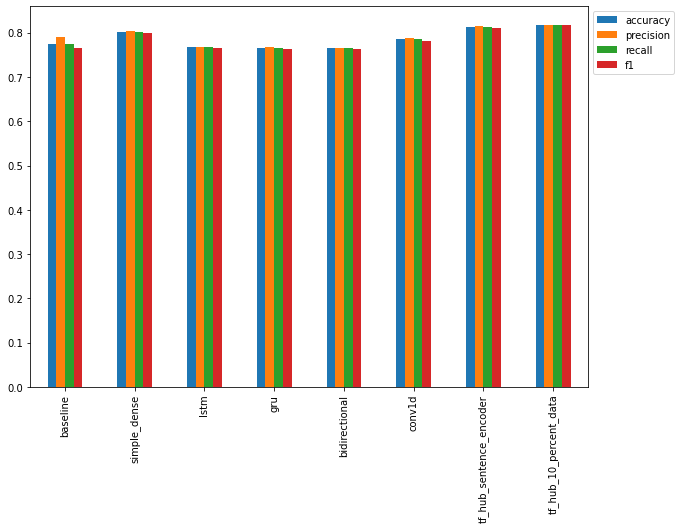

In [100]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

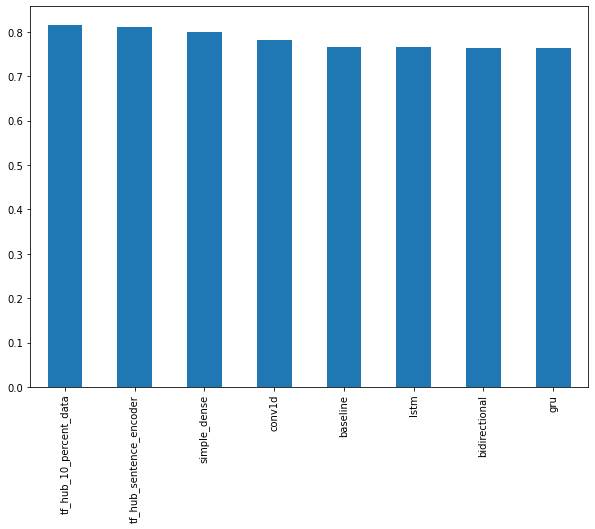

In [101]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [102]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP Disaster prediction - modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

## Saving and loading the best model

In [103]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [104]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [105]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4093 - accuracy: 0.8123


[0.4093165695667267, 0.8123359680175781]

In [106]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [107]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [108]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4093 - accuracy: 0.8123


[0.4093165695667267, 0.8123359680175781]

## Finding wrong predictions

In [109]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,beautiful disaster https://t.co/qm5Sz0fyU8,0,0.0,0.406149
1,I'm setting myself up for disaster,0,0.0,0.121782
2,.@uriminzok The coming catastrophe of the dest...,0,0.0,0.180690
3,A demolished Palestinian village comes back to...,1,1.0,0.945392
4,I-77 Mile Marker 31 to 40 South Mooresville I...,1,1.0,0.963890


In [111]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
412,Truck Driver Salvages Banned Tomatoes From Des...,0,1.0,0.906315
131,How can we help save a beautiful town in Ontar...,0,1.0,0.902639
35,Emergency Dispatchers in Boone County in the h...,0,1.0,0.901404
622,Governor allows parole for California school b...,0,1.0,0.900145
389,Former Township fire truck being used in Phili...,0,1.0,0.896263
161,wowo--=== 12000 Nigerian refugees repatriated ...,0,1.0,0.840420
751,On Thursday at 00:25 we updated our #kml of 2D...,0,1.0,0.836940
718,.POTUS #StrategicPatience is a strategy for #G...,0,1.0,0.826702
609,29% of #oil and #gas organizations have no rea...,0,1.0,0.777920
150,Alaska's #Wolves face catastrophe Denali Wolve...,0,1.0,0.774543


In [112]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")  

Target: 0, Pred: 1, Prob: 0.9063146114349365
Text:
Truck Driver Salvages Banned Tomatoes From Destruction on #Russian Border http://t.co/7b2Wf6ovFK #news

----

Target: 0, Pred: 1, Prob: 0.9026392102241516
Text:
How can we help save a beautiful town in Ontario from destruction by a power plant developer?
http://t.co/hlD5xLYwBn

----

Target: 0, Pred: 1, Prob: 0.9014040231704712
Text:
Emergency Dispatchers in Boone County in the hot seat http://t.co/5fHkxtrhYU

----

Target: 0, Pred: 1, Prob: 0.9001454710960388
Text:
Governor allows parole for California school bus hijacker | Fresno Linked Local Network http://t.co/Sww0QsMxVM http://t.co/bcdP4gKokA

----

Target: 0, Pred: 1, Prob: 0.896263062953949
Text:
Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino

----

Target: 0, Pred: 1, Prob: 0.8404203057289124
Text:
wowo--=== 12000 Nigerian refugees repatriated from Cameroon

----

Target: 0, Pred: 1, Prob: 0.8369402885437012
Text:
On Thursd

In [113]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.08752361685037613
Text:
'Money can't buy happiness' is just a lie we tell poor people to keep them from rioting.

----

Target: 1, Pred: 0, Prob: 0.0852312296628952
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.07624858617782593
Text:
@gilderoy i wish i was good enough to add flames to my nails im on fire

----

Target: 1, Pred: 0, Prob: 0.07591307163238525
Text:
#hot  Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/nGKrZPza45 #prebreak #best

----

Target: 1, Pred: 0, Prob: 0.06733572483062744
Text:
STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/xFguklrlTf http://t.co/FeGu8hWMc4

----

Target: 1, Pred: 0, Prob: 0.061837952584028244
Text:
Keeps askin me what this means
Not like i got the answers
Plus if i say the wrong thing
This might just turn into a disaster

----

Target: 1, Pred: 0, Prob: 0.0613447576761245

## Predictions on the test dataset

In [114]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 54ms/step
Pred: 0, Prob: 0.057865697890520096
Text:
Beauty Deals : http://t.co/eUd317Eptp #4552 Lot of 50Mixed Colors 7.5' Scissors FirstAid Princess Care Rescue TrÛ_ http://t.co/mAHkV79SmW

----

1/1 [==============================] - 0s 29ms/step
Pred: 1, Prob: 0.5622856020927429
Text:
Aftershock https://t.co/Ecy4U623nO

----

1/1 [==============================] - 0s 30ms/step
Pred: 1, Prob: 0.9313547611236572
Text:
Cheesehead Report - Arson charges filed in Jackson County house fire http://t.co/I3Y1ZWjBzO

----

1/1 [==============================] - 0s 70ms/step
Pred: 0, Prob: 0.1618330031633377
Text:
Hope someone buys it! Former post office in Napa now for sale http://t.co/2ZeV1Zyttg #preservation

----

1/1 [==============================] - 0s 64ms/step
Pred: 0, Prob: 0.03378579393029213
Text:
Smackdown tyme this should put me in a good mood again since it got wrecked smh

----

1/1 [==============================] - 0s 53ms/step
Pred:

## Predicting with random tweets

In [117]:
# Turn Tweet into string
test_tweet_1 = "Plan is to throw a party in the Andromeda galaxy 1B years from now. Everyone welcome, except for those who litter"

In [118]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [119]:
# Make a prediction on random Tweets 
predict_on_sentence(model=model_6, sentence=test_tweet_1)

1/1 [==============================] - 0s 30ms/step
Pred: 0.0 (not real disaster) Prob: 0.08693590015172958
Text:
Plan is to throw a party in the Andromeda galaxy 1B years from now. Everyone welcome, except for those who litter


In [120]:
test_tweet_2 = "What Adani’s Downfall Tells Us About India’s Crony Capitalism"
predict_on_sentence(model=model_6, sentence=test_tweet_2)

1/1 [==============================] - 0s 83ms/step
Pred: 0.0 (not real disaster) Prob: 0.0723281055688858
Text:
What Adani’s Downfall Tells Us About India’s Crony Capitalism


In [121]:
test_tweet_3 = "#Stockmarketcrash trends on Twitter as Adani stocks continue to fall after Hindenburg’s report"
predict_on_sentence(model=model_6, sentence=test_tweet_3)

1/1 [==============================] - 0s 31ms/step
Pred: 0.0 (not real disaster) Prob: 0.22238346934318542
Text:
#Stockmarketcrash trends on Twitter as Adani stocks continue to fall after Hindenburg’s report


In [122]:
test_tweet_4 = "Climate change trauma has real impacts on cognition and the brain, wildfire survivors study shows"
predict_on_sentence(model=model_6, sentence=test_tweet_4)

1/1 [==============================] - 0s 32ms/step
Pred: 1.0 (real disaster) Prob: 0.9516667127609253
Text:
Climate change trauma has real impacts on cognition and the brain, wildfire survivors study shows
